# **Building a CNN: Filters, Layers, Flattening, and Receptive Field**


In [1]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass


import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # tensorflow INFO and WARNING messages are not printed 

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import PIL
from PIL import Image, ImageOps
import tensorflow as tf

import glob
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [3]:
def calc_rf(model):
    # Initialize an array storing all the layers' receptive field sizes and set layer 0 (input) RF to 1
    num_layers = len(model.layers)
    rf_arr = np.empty(num_layers+1, dtype=int)
    rf_arr[0] = 1
    # Initialize an array storing all the layers' jump sizes and set layer 0 (input) jump to 1
    j_arr = np.empty(num_layers+1, dtype=int)
    j_arr[0] = 1
    
    for i in range(num_layers):
        layer = model.layers[i]
        k = layer.kernel_size[0]
        s = layer.strides[0]
        j_in = j_arr[i]
        j_out = j_in * s
        r_out = rf_arr[i] + (k - 1) * j_in
        j_arr[i+1] = j_out
        rf_arr[i+1] = r_out        
        print("Layer {}: {} \n Jump Size: {}\n Effective Receptive Field Size: {}".format(i+1, layer.name, j_arr[i+1], rf_arr[i+1]))
        print("------")

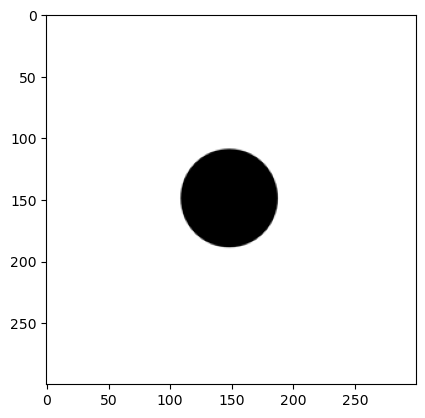

In [4]:
img_width, img_height = 300, 300
dot = PIL.Image.open("RF_dot.png")
dot = ImageOps.grayscale(dot)
dot = dot.resize((img_width, img_height))
plt.imshow(dot, cmap='gray')
plt.show()

### Model 1: No Stride

To begin, we'll check what the output looks like when we have a model with no stride. With the parameters specified, our ERF should be 3 for the output.


In [5]:
kernel = (1/9)*np.ones((3,3,1,1))
b = np.array([0.0])

In [6]:
model1 = Sequential()
model1.add(Conv2D(input_shape=(img_width, img_height, 1), filters=1, kernel_size = (3, 3)))
model1.layers[0].set_weights([kernel, b])
calc_rf(model=model1)

Layer 1: conv2d 
 Jump Size: 1
 Effective Receptive Field Size: 3
------


### Model 2: Increased Stride

In [7]:
model2 = Sequential()
model2.add(Conv2D(input_shape=(img_width, img_height, 1), filters=1, padding='same', strides=2,kernel_size = (3, 3)))
model2.layers[0].set_weights([kernel, b])
calc_rf(model=model2)

Layer 1: conv2d_1 
 Jump Size: 2
 Effective Receptive Field Size: 3
------


### Model 3: Increased Layers


In [8]:
model3 = Sequential()

model3.add(Conv2D(input_shape = (img_width, img_height, 1),
                 filters=1, 
                 kernel_size=(3,3)
                 ))
model3.add(Conv2D(filters=1, 
                 kernel_size=(3,3), 
                 strides=4
                 ))
model3.add(Conv2D(filters=1, 
                 kernel_size=(3,3), 
                 strides=5
                 ))

model3.layers[0].set_weights([kernel,b])
model3.layers[1].set_weights([kernel,b])
model3.layers[2].set_weights([kernel,b])

calc_rf(model3)

Layer 1: conv2d_2 
 Jump Size: 1
 Effective Receptive Field Size: 3
------
Layer 2: conv2d_3 
 Jump Size: 4
 Effective Receptive Field Size: 5
------
Layer 3: conv2d_4 
 Jump Size: 20
 Effective Receptive Field Size: 13
------


### Visualizing the Outputs


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


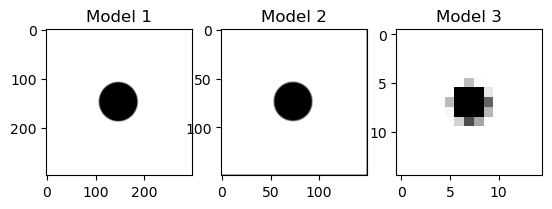

In [9]:
models = [model1, model2, model3]
dot_tensor = np.array(dot).reshape((1, img_width, img_height, 1))
fig, ax = plt.subplots(1, len(models))
for i in range(len(models)):
    plt.subplot(1, len(models), i+1)
    output = models[i].predict(dot_tensor)
    output = output.reshape(output.shape[1], output.shape[2])
    plt.title("Model {}".format(i+1))
    plt.imshow(output, cmap='gray')

## Varied Input-Output Relationships


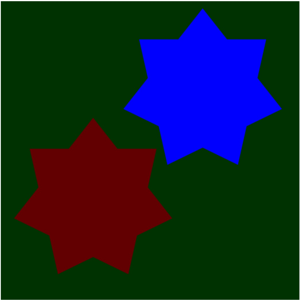

In [10]:
img_width, img_height = 300, 300
img = PIL.Image.open("channel_image.jpg").resize((img_width, img_height))
img

In [11]:
def edge_grad(shape, dtype=None):
    grad = np.array([
        [-1, -1, -1],
        [-1, 8, -1],
        [-1, -1, -1]
        ]).reshape(shape)
    
    return grad

def sharpen_grad(shape, dtype=None):
    grad = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ]).reshape(shape)
    
    return grad

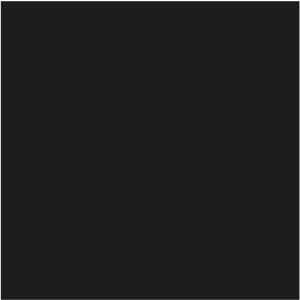

In [12]:
gray = ImageOps.grayscale(img)
img_tensor = np.array(gray).reshape((1, img_width, img_height, 1)) # Convert to a tensor for model prediction
gray

In [13]:
kernels = np.array([sharpen_grad((3,3,1,1)), edge_grad((3,3,1,1))])
kernels = kernels.reshape((3,3,1,2))
b = np.array([np.array([0.0]),np.array([0.0])]).reshape(2,)

In [17]:
model = Sequential()

model.add(Conv2D(filters = 2, 
                 kernel_size = (3, 3), 
                 padding='same', 
                 input_shape = (img_width, img_height, 1)))

model.set_weights([kernels,b])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 300, 300, 2)         │              20 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
model = Sequential()
model.add(Conv2D(filters=2, 
                 kernel_size=(3, 3), 
                 padding='same', 
                 input_shape=(img_width, img_height, 1)))

model.set_weights([kernels, b])

model.summary()

layer_outputs = [layer.output for layer in model.layers]  # Extracts the outputs of the layer
activation_model = Model(inputs=model.input, outputs=layer_outputs);activation_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 300, 300, 2)         │              20 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

ValueError: The layer sequential_6 has never been called and thus has no defined input.

In [ ]:
activations = activation_model.predict(img_tensor) # Obtain the outputs (activations) from our model

In [ ]:
filter_outputs = activations[0]  # Extract the outputs from the first (in this case, the only) layer of the model
print(filter_outputs.shape)

In [ ]:
# Display weights of the first filter of this layer
filter_outputs[:,:,0]

In [ ]:
names = ["Sharpening Filter", "Edge Filter"]
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(filter_outputs[:,:,i], cmap='gray')
    plt.axis("off")
    plt.title(f"{names[i]}", fontsize=13)

### Multiple Inputs, Single Output


In [21]:
img_tensor = np.array(img).reshape((1, img_width, img_height, 3))

In [22]:
kernel = np.array([sharpen_grad((3,3,1,1)), sharpen_grad((3,3,1,1)), sharpen_grad((3,3,1,1))])
kernel = kernel.reshape((3,3,3,1))
b = np.array([0.0])

In [23]:
model = Sequential()

model.add(Conv2D(filters = 1, 
                 kernel_size = (3, 3), 
                 padding='same', 
                 input_shape = (img_width, img_height, 3)))

model.set_weights([kernel,b])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 300, 300, 1)         │              28 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
output = model.predict(img_tensor)
output = output.reshape((img_width, img_height))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


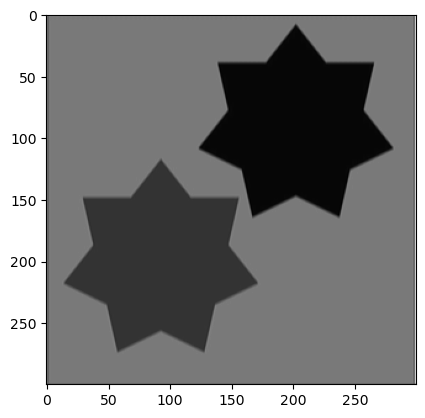

In [25]:
plt.imshow(output, cmap='gray')

### Multiple Inputs, Multiple Outputs


In [27]:
img_tensor = np.array(img).reshape((1, img_width, img_height, 3))

In [28]:
kernel = np.zeros((3,3,3,2))

kernel[0] = np.dstack([sharpen_grad((3,3,1)),edge_grad((3,3,1))])
kernel[1] = np.dstack([sharpen_grad((3,3,1)),edge_grad((3,3,1))])
kernel[2] = np.dstack([sharpen_grad((3,3,1)),edge_grad((3,3,1))])

kernel = kernel.reshape((3,3,3,2))

In [29]:
b = np.array([np.array([0.0]),np.array([0.0])]).reshape(2,)

In [30]:
model = Sequential()

model.add(Conv2D(filters = 2, 
                 kernel_size = (3, 3), 
                 padding='same', 
                 input_shape = (img_width, img_height, 3)))

model.set_weights([kernel,b])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 300, 300, 2)         │              56 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56 (224.00 B)

 Trainable params: 56 (224.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
layer_outputs = [layer.output for layer in model.layers] 
activation_model = Model(inputs=model.input, outputs=layer_outputs) 
activations = activation_model.predict(img_tensor)
filter_outputs = activations[0]

ValueError: The layer sequential_8 has never been called and thus has no defined input.

In [ ]:
plt.imshow(filter_outputs[:,:,0],cmap='gray') # Print out the convolved result of the first filter

In [ ]:
# Display the filter outputs
names = ["Sharpening Filter", "Edge Filter"]
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(filter_outputs[:,:,i], cmap='gray')
    plt.axis("off")
    plt.title(f"{names[i]}", fontsize=13)

## Deeper CNNs


In [32]:
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/flower_photos.tgz"
data_dir = keras.utils.get_file(origin=dataset_url,
                                fname='flower_photos',
                                untar=True)

data_dir = pathlib.Path(data_dir)

for folder in data_dir.glob('[!LICENSE]*'):
    print('The', folder.name, 'folder has',
          len(list(folder.glob('*.jpg'))), 'pictures')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count, 'total images')

The daisy folder has 633 pictures
The dandelion folder has 898 pictures
The roses folder has 641 pictures
The tulips folder has 799 pictures
3670 total images


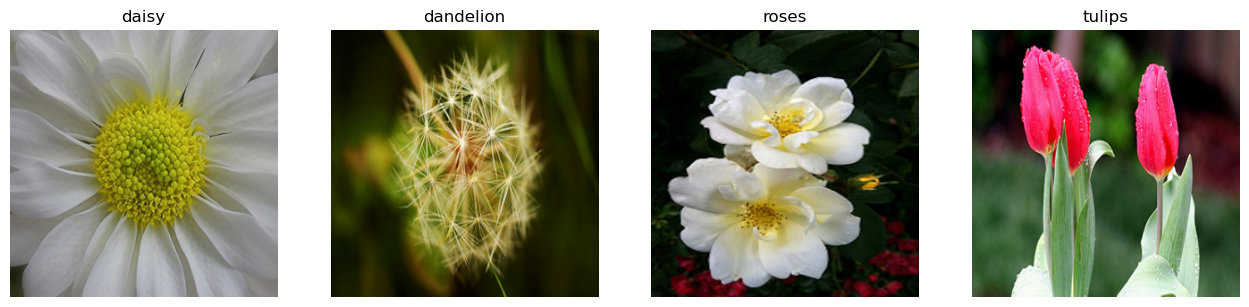

In [33]:
pics = list()
pics_arr = list()
p_class = list()

img_width = 300
img_height = 300

plt.figure(figsize=(20,5))
for idx, folder in enumerate(data_dir.glob('[!LICENSE]*')):
    cat = list(data_dir.glob(folder.name + '/*'))
    pic = PIL.Image.open(str(cat[0])).resize((img_width, img_height))
    pic_arr = np.array(pic)
    clss = folder.name
    
    plt.subplot(1,5,idx+1)
    plt.imshow(pic)
    plt.title(clss)
    plt.axis('off')
    
    pics.append(pic)
    pics_arr.append(pic_arr)
    p_class.append(clss)
    

#### Exercise: Define the model and add the first layer

Define the Sequential model and add the following layer to our classifier:

1.  Convolutional layer with 3 input channels, three 3x3 filters, even padding, and relu activation function.


In [34]:
classifier = Sequential()
classifier.add(Conv2D(3, (3, 3), padding='same', input_shape=(img_width, img_height, 3), activation='relu'))

#### Exercise: Add additional layers

In Keras, you can simply call `add()` to add multiple layers to the Sequential model you've defined.

1.  Convolutional layer with two 3x3 filters and sigmoid activation function.
2.  Convolutional layer with six 5x5 filters, stride = 4, even padding, and relu activation function.
3.  Max pooling layer with size 2x2.


In [36]:
classifier.add(Conv2D(2, (3, 3), activation='sigmoid'))
classifier.add(Conv2D(6, (5, 5), strides = 4, padding='same', activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2))) 

In [37]:
classifier.add(Flatten())

In [38]:
classifier.add(Dense(units=512, activation='relu'))

In [39]:
classifier.add(Dense(5, activation='softmax'))

In [40]:
classifier.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 300, 300, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 298, 298, 2)         │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 75, 75, 6)           │             306 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 73, 73, 2)           │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 19, 19, 6)           │             306 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 6)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 486)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         249,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,771 (987.39 KB)

 Trainable params: 252,771 (987.39 KB)

 Non-trainable params: 0 (0.00 B)